In [1]:
import glob
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from biom import load_table
from tqdm.notebook import tqdm
from skbio.stats.distance import permanova
from scipy.spatial import distance
from scipy.linalg import khatri_rao
from skbio import DistanceMatrix
from gemelli.ctf import ctf
from gemelli.joint_ctf import joint_ctf
from gemelli.preprocessing import clr_transformation
# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

### functions

In [2]:
def plot_loadings(loadings, mf, 
                  mod_name, comp1, comp2, 
                  cat_of_interest, group_colors):
    
    t_load, s_load, f_load = loadings
    pc_colors = {'component_1': 'tab:purple',
                 'component_2': 'tab:orange',
                 'component_3': 'tab:grey'}
    
    # Plotting temporal loadings
    fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
    sns.lineplot(data=t_load[mod_name][['component_1', 
                                        'component_2', 
                                        'component_3']], 
                 ax=axn[0], dashes=False, palette=pc_colors)
    axn[0].set_title('Temporal Loadings', fontsize=14)
    axn[0].legend()
    axn[0].set_xlabel('Resolution')
    axn[0].set_ylabel('Loadings')
    # Plotting subject loadings
    sns.scatterplot(x=s_load[mod_name][comp1], 
                    y=s_load[mod_name][comp2],  
                    ax=axn[1], hue=mf[cat_of_interest], 
                    palette=group_colors)
    axn[1].set_title('Subject Loadings', fontsize=14)
    axn[1].legend(loc='best')
    # Plotting feature loadings
    sns.scatterplot(x=f_load[mod_name][comp1], 
                    y=f_load[mod_name][comp2], 
                    ax=axn[2], color='black')
    axn[2].set_title('Feature Loadings', fontsize=14)
    # Adjusting titles and labels
    plt.suptitle('Joint-CTF results ({})'.format(mod_name), 
                 fontsize=16, x=0.52, y=1)
    for ax in axn[1:2]:
        ax.set_xlabel(comp1.replace('_', ' '))
        ax.set_ylabel(comp2.replace('_', ' '))
    plt.tight_layout()

def plot_feature_cov(tables, mod_cov, components,
                     sharey=True, axis_off=True):
    
    #get feature IDs for each modality
    feature_order = []
    for table in tables:
        feature_ids = table.ids(axis='observation').tolist()
        feature_order = feature_order + feature_ids

    n_comp = len(components)
    fig, axn = plt.subplots(1, n_comp, figsize=(5*n_comp, 4), 
                            sharey=sharey)

    for i, component in enumerate(components):
        cov_table = mod_cov[component]
        cov_table = cov_table.loc[feature_order, feature_order]
        #plot heatmap of feature covariance matrix
        sns.heatmap(cov_table, robust=True, cmap='vlag', 
                    center=0, ax=axn[i])
        axn[i].set_title('{}'.format(component))
    
    if axis_off:
        for ax in axn:
            ax.set_yticks([])
            ax.set_xticks([])

    plt.suptitle('Feature covariance', fontsize=16, y=1.02)
    #plt.show()

def sub_feat_trajectory(table, feature_loadings, 
                        component, modality, zoom=True, 
                        quantile=0.95, pseudocount=0):
    # get the loadings
    floadings = feature_loadings[modality][component].copy()
    table_df = table.copy().to_dataframe()

    if zoom:
        #get top and bottom loading quantiles
        top_q = floadings.quantile(quantile)
        bottom_q = floadings.quantile(1-quantile)
        top_fts = floadings[floadings >= top_q].index
        bottom_fts = floadings[floadings <= bottom_q].index
        
        num = table_df.loc[top_fts].sum(axis=0)
        num += pseudocount
        denom = table_df.loc[bottom_fts].sum(axis=0)
        denom += pseudocount

        beta_l = np.log(num).values - np.log(denom).values
        beta_l = pd.DataFrame(beta_l, index=num.index, 
                              columns=[component])
    else:
        #calculate trajectories
        pass

    #drop any NaNs
    beta_l.dropna(inplace=True)

    return beta_l, top_fts, bottom_fts

def temporal_trajectory(individual_loadings, 
                        feature_loadings,
                        temporal_loadings, 
                        state_column, modality, 
                        component = 'component_1',
                        f_subset=True, quantile=0.95):
    #get loadings
    sloadings = individual_loadings[[component]].copy()
    floadings = feature_loadings[modality][[component]].copy()
    t_index = temporal_loadings[modality]['time_interval']
    tloadings = temporal_loadings[modality][[component]].copy()
    #add dummy column to all loadings
    sloadings['dummy'] = 1
    floadings['dummy'] = 1
    tloadings['dummy'] = 1

    #calculate the column-wise khatri-rao products
    #subject trajectory
    s_traj = khatri_rao(sloadings, tloadings)
    s_traj = pd.DataFrame(s_traj, columns=[component,'dummy'])
    #add subject IDs and resolution
    a_indexes_repeated = np.repeat(sloadings.index, tloadings.shape[0])
    c_indexes_tiled = np.tile(t_index, sloadings.shape[0])
    s_traj['subjectID'] = a_indexes_repeated
    s_traj[state_column] = c_indexes_tiled
    
    #feature trajectory
    if f_subset:
        #get top and bottom loading quantiles
        top_q = floadings[component].quantile(quantile)
        bottom_q = floadings[component].quantile(1-quantile)
        top_fts = floadings[floadings[component] >= top_q].index.tolist()
        bottom_fts = floadings[floadings[component] <= bottom_q].index.tolist()
        floadings = floadings.loc[top_fts+bottom_fts]
        f_traj = khatri_rao(floadings, tloadings)
    else:
        f_traj = khatri_rao(floadings, tloadings)
    
    f_traj = pd.DataFrame(f_traj, columns=[component,'dummy'])
    #add feature IDs and resolution
    b_indexes_repeated = np.repeat(floadings.index, tloadings.shape[0])
    c_indexes_tiled = np.tile(t_index, floadings.shape[0])
    f_traj['featureID'] = b_indexes_repeated
    f_traj[state_column] = c_indexes_tiled
    #if top/bottom features used, label them accordingly
    if f_subset:
        f_traj['quantile'] = ['top_q' if x in top_fts else 'bottom_q' for x in f_traj.featureID]

    #remove dummy columns
    s_traj.drop(columns=['dummy'], inplace=True)
    f_traj.drop(columns=['dummy'], inplace=True)
    return s_traj, f_traj

### load and preprocess data

In [2]:
# load filtered tables
body_site = 'Baby-Feces'
baby_gut_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
baby_gut_table = load_table('../data/%s/table-filtered.biom' % body_site)

body_site = 'Baby-Forearm'
baby_skin_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
baby_skin_table = load_table('../data/%s/table-filtered.biom' % body_site)

body_site = 'Baby-Mouth'
baby_mouth_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
baby_mouth_table = load_table('../data/%s/table-filtered.biom' % body_site)

In [3]:
#calculate sequencing depth in each table
baby_gut_df = baby_gut_table.to_dataframe()
baby_skin_df = baby_skin_table.to_dataframe()

#calculate the average count for each sample
gut_depth = baby_gut_df.sum(axis=0).sum()/baby_gut_df.shape[1]
skin_depth = baby_skin_df.sum(axis=0).sum()/baby_skin_df.shape[1]
print('Avg count in gut samples: %.2f' % gut_depth)
print('Avg count in skin samples: %.2f' % skin_depth)

Avg count in gut samples: 57830.48
Avg count in skin samples: 38653.87


In [4]:
#calculate the average count for each feature
gut_depth = baby_gut_df.sum(axis=0).sum()/baby_gut_df.shape[0]
skin_depth = baby_skin_df.sum(axis=0).sum()/baby_skin_df.shape[0]
print('Avg count in gut features: %.2f' % gut_depth)
print('Avg count in skin features: %.2f' % skin_depth)

Avg count in gut features: 21414.99
Avg count in skin features: 2511.26


### Joint-CTF with true data

In [5]:
# define temporary output directory
n_mods = 2
output_dir = '/Users/bec5786/Desktop/temp/joint_ctf_out/mod{}/'.format(n_mods)
csseed = False
tps = 'all'
body_site_save = 'Gut-Skin'
body_site1_title = 'Gut'
body_site2_title = 'Skin'

if csseed:
    output_dir = '{}CSseed_true/'.format(output_dir)
else:
    output_dir = '{}CSseed_false/'.format(output_dir)

In [6]:
#decide which datasets to use
mf1 = baby_gut_mf.copy()
table1 = baby_gut_table.copy()
mf2 = baby_skin_mf.copy()
table2 = baby_skin_table.copy()

In [7]:
#(optional) subsetting
#define time splits
state_column = 'date_sampling_category_days_continuous'
splits_ = {'all':[0.0, 1.0, 2.0, 7.0, 14.0, 
                  21.0, 30.0, 60.0, 90.0, 120.0, 
                  150.0, 180.0, 210.0, 240.0, 
                  270.0, 300.0, 330.0, 360.0],
           '0-2':[0.0, 1.0, 2.0],
           '7-360':[7.0, 14.0, 30.0,
                    60, 120, 180, 360]}

if csseed == False:
    mf1 = mf1[mf1.birth_mode_ms != 'CSseed']
    mf2 = mf2[mf2.birth_mode_ms != 'CSseed']

# mf1_120sub = mf1[mf1.date_sampling_category_days_continuous <= 120]
# mf2_120sub = mf2[mf2.date_sampling_category_days_continuous <= 120]

In [8]:
#pick the metadata to be used (original or subset)
if tps == '7-360':
    mf1 = mf1[mf1[state_column].isin(splits_['7-360'])]
    mf2 = mf2[mf2[state_column].isin(splits_['7-360'])]

In [9]:
#make sure there are at least two time points per subject
subject_id_column = 'subjectid_unique'
ids_to_keep1 = mf1[subject_id_column].value_counts()[mf1[subject_id_column].value_counts() > 1].index
mf1 = mf1[mf1[subject_id_column].isin(ids_to_keep1)]

ids_to_keep2 = mf2[subject_id_column].value_counts()[mf2[subject_id_column].value_counts() > 1].index
mf2 = mf2[mf2[subject_id_column].isin(ids_to_keep2)]

In [10]:
##2 modalities
#ensure subjects are shared across modalities
shared_subjects = [s_id for s_id in mf1.subjectid_unique.unique() if s_id in mf2.subjectid_unique.unique()]
print("# shared subjects: {}".format(len(shared_subjects)))
mf1 = mf1[mf1.subjectid_unique.isin(shared_subjects)]
mf2 = mf2[mf2.subjectid_unique.isin(shared_subjects)]
#sanity check
print(len(mf1.subjectid_unique.unique()))
print(len(mf2.subjectid_unique.unique()))

# shared subjects: 71
71
71


In [11]:
print(len(mf1[mf1.birth_mode_ms == 'CS']['subjectid_unique'].unique()))
print(len(mf1[mf1.birth_mode_ms == 'Vag']['subjectid_unique'].unique()))

14
57


In [12]:
#count number of babies in each category for each time point
for tp in splits_['all']:
    print(tp)
    print(mf1[mf1.date_sampling_category_days_continuous == tp].birth_mode_ms.value_counts())
    print(mf2[mf2.date_sampling_category_days_continuous == tp].birth_mode_ms.value_counts())

0.0
Vag    30
CS      4
Name: birth_mode_ms, dtype: int64
Vag    35
CS      2
Name: birth_mode_ms, dtype: int64
1.0
Vag    35
CS      7
Name: birth_mode_ms, dtype: int64
Vag    39
CS      6
Name: birth_mode_ms, dtype: int64
2.0
Vag    27
CS      2
Name: birth_mode_ms, dtype: int64
Vag    34
CS      8
Name: birth_mode_ms, dtype: int64
7.0
Vag    51
CS     13
Name: birth_mode_ms, dtype: int64
Vag    49
CS     10
Name: birth_mode_ms, dtype: int64
14.0
Vag    52
CS     10
Name: birth_mode_ms, dtype: int64
Vag    49
CS     13
Name: birth_mode_ms, dtype: int64
21.0
Vag    42
CS      5
Name: birth_mode_ms, dtype: int64
Vag    43
CS      7
Name: birth_mode_ms, dtype: int64
30.0
Vag    47
CS     14
Name: birth_mode_ms, dtype: int64
Vag    48
CS     14
Name: birth_mode_ms, dtype: int64
60.0
Vag    15
CS     11
Name: birth_mode_ms, dtype: int64
Vag    19
CS     12
Name: birth_mode_ms, dtype: int64
90.0
Vag    13
CS      6
Name: birth_mode_ms, dtype: int64
Vag    13
CS      3
Name: birth_mode_ms, 

In [ ]:
# ##3 modalities
# #ensure subjects are shared across modalities
# #ensure subjects are shared across modalities
# shared_subjects = [s_id for s_id in mf1.subjectid_unique.unique() if s_id in mf2.subjectid_unique.unique()]
# shared_subjects = [s_id for s_id in shared_subjects if s_id in mf3.subjectid_unique.unique()]
# print("# shared subjects: {}".format(len(shared_subjects)))
# mf1 = mf1[mf1.subjectid_unique.isin(shared_subjects)]
# mf2 = mf2[mf2.subjectid_unique.isin(shared_subjects)]
# mf3 = mf3[mf3.subjectid_unique.isin(shared_subjects)]
# #sanity check
# print(len(mf1.subjectid_unique.unique()))
# print(len(mf2.subjectid_unique.unique()))
# print(len(mf3.subjectid_unique.unique()))

In [13]:
#subset tables prior to transformation
table1 = table1.filter(mf1.index, axis='sample')
table2 = table2.filter(mf2.index, axis='sample')

table1_clr = clr_transformation(table1.copy(), pseudocount=0.5)
table2_clr = clr_transformation(table2.copy(), pseudocount=0.5)

In [14]:
ctf_results = joint_ctf(tables=[table1_clr, table2_clr],
                        sample_metadatas=[mf1, mf2],
                        modality_ids=['16S.1','16S.2'],
                        individual_id_column='subjectid_unique',
                        state_column='date_sampling_category_days_continuous')

(subject_loads, feature_loads, state_loads, 
 subject_lambdas, var_explained, feature_covs) = ctf_results

Calculate components for component_1
Reached convergence in 16 iterations
Calculate components for component_2
Reached convergence in 11 iterations
Calculate components for component_3
Reached convergence in 16 iterations


In [15]:
# #save the results
# for mod, bsite in zip(['16S.1','16S.2'], [body_site1_title, body_site2_title]):
#     subject_loads[mod].to_csv('{}loadings/{}_{}_subject_loadings_{}.tsv'.format(output_dir, body_site_save, bsite, tps), sep='\t')
#     feature_loads[mod].to_csv('{}loadings/{}_{}_feature_loadings_{}.tsv'.format(output_dir, body_site_save, bsite, tps), sep='\t')
#     state_loads[mod].to_csv('{}loadings/{}_{}_temporal_loadings_{}.tsv'.format(output_dir, body_site_save, bsite, tps), sep='\t')

# subject_lambdas.to_csv('{}loadings/{}_lambdas_{}.tsv'.format(output_dir, body_site_save, tps), sep='\t')
# var_explained.T.to_csv('{}loadings/{}_var_explained_{}.tsv'.format(output_dir, body_site_save, tps), sep='\t')    
# for component, pc in zip(['component_1', 'component_2', 'component_3'], ['PC1', 'PC2', 'PC3']):
#         feature_covs[component].to_csv('{}loadings/{}_feature_covs_{}_{}.tsv'.format(output_dir, body_site_save, bsite, pc, tps), sep='\t')

In [16]:
comp1 = 'component_1'
comp2 = 'component_2'
cat_of_interest = 'birth_mode_ms'
state_column = 'date_sampling_category_days_continuous'
baby_combined_mf = pd.concat([mf1, mf2])
mf_all = baby_combined_mf.groupby('subjectid_unique').agg({cat_of_interest:'first',
                                                           'country':'first'})

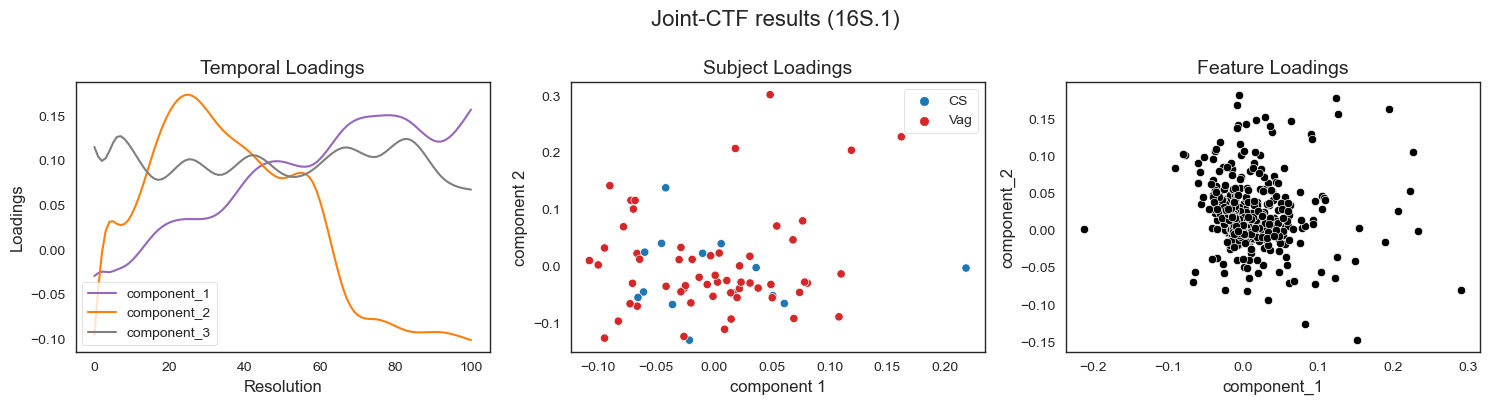

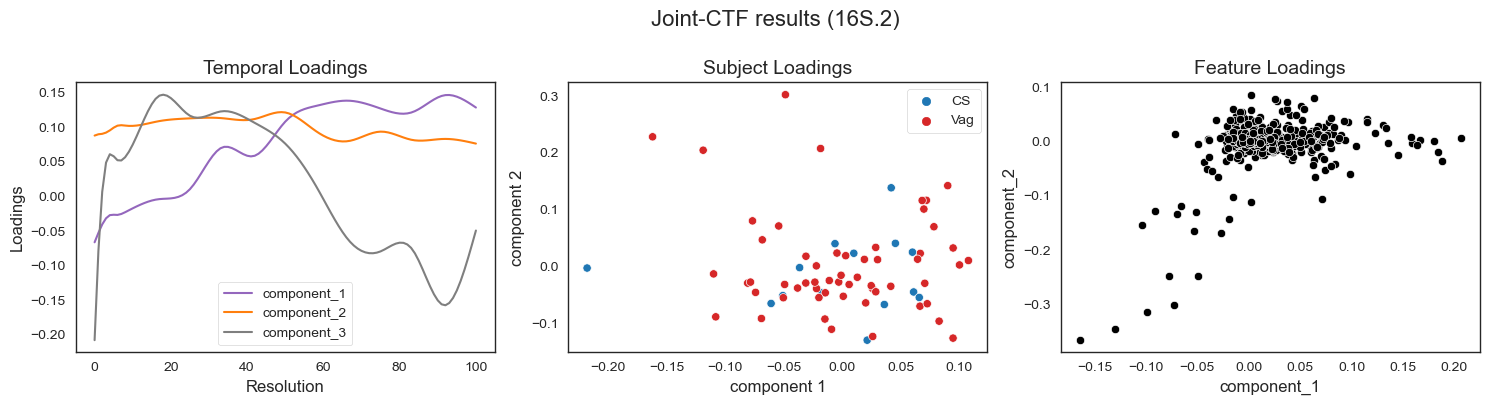

In [18]:
group_colors = {'CS': 'tab:blue', 'CSseed': 'tab:green', 'Vag': 'tab:red'}

plot_loadings(loadings=[state_loads, subject_loads, feature_loads], 
              mf=mf_all, mod_name='16S.1', 
              comp1='component_1', comp2='component_2', 
              cat_of_interest='birth_mode_ms', group_colors=group_colors)
plt.savefig('{}png/{}_{}_loadings_{}.png'.format(output_dir, body_site_save, body_site1_title, tps), dpi=300)
plt.show()

plot_loadings(loadings=[state_loads, subject_loads, feature_loads], 
              mf=mf_all, mod_name='16S.2', 
              comp1='component_1', comp2='component_2', 
              cat_of_interest='birth_mode_ms', group_colors=group_colors)
#plt.savefig('{}png/{}_{}_loadings_{}.png'.format(output_dir, body_site_save, body_site2_title, tps), dpi=300)
plt.show()

In [19]:
print(subject_lambdas)
print(var_explained.T)

       component_1  component_2  component_3
16S.1   677.408157   628.534906   325.113297
16S.2  1043.633600   543.280975   332.985285
               component_1  component_2  component_3
var_explained     0.436398     0.327324     0.236278


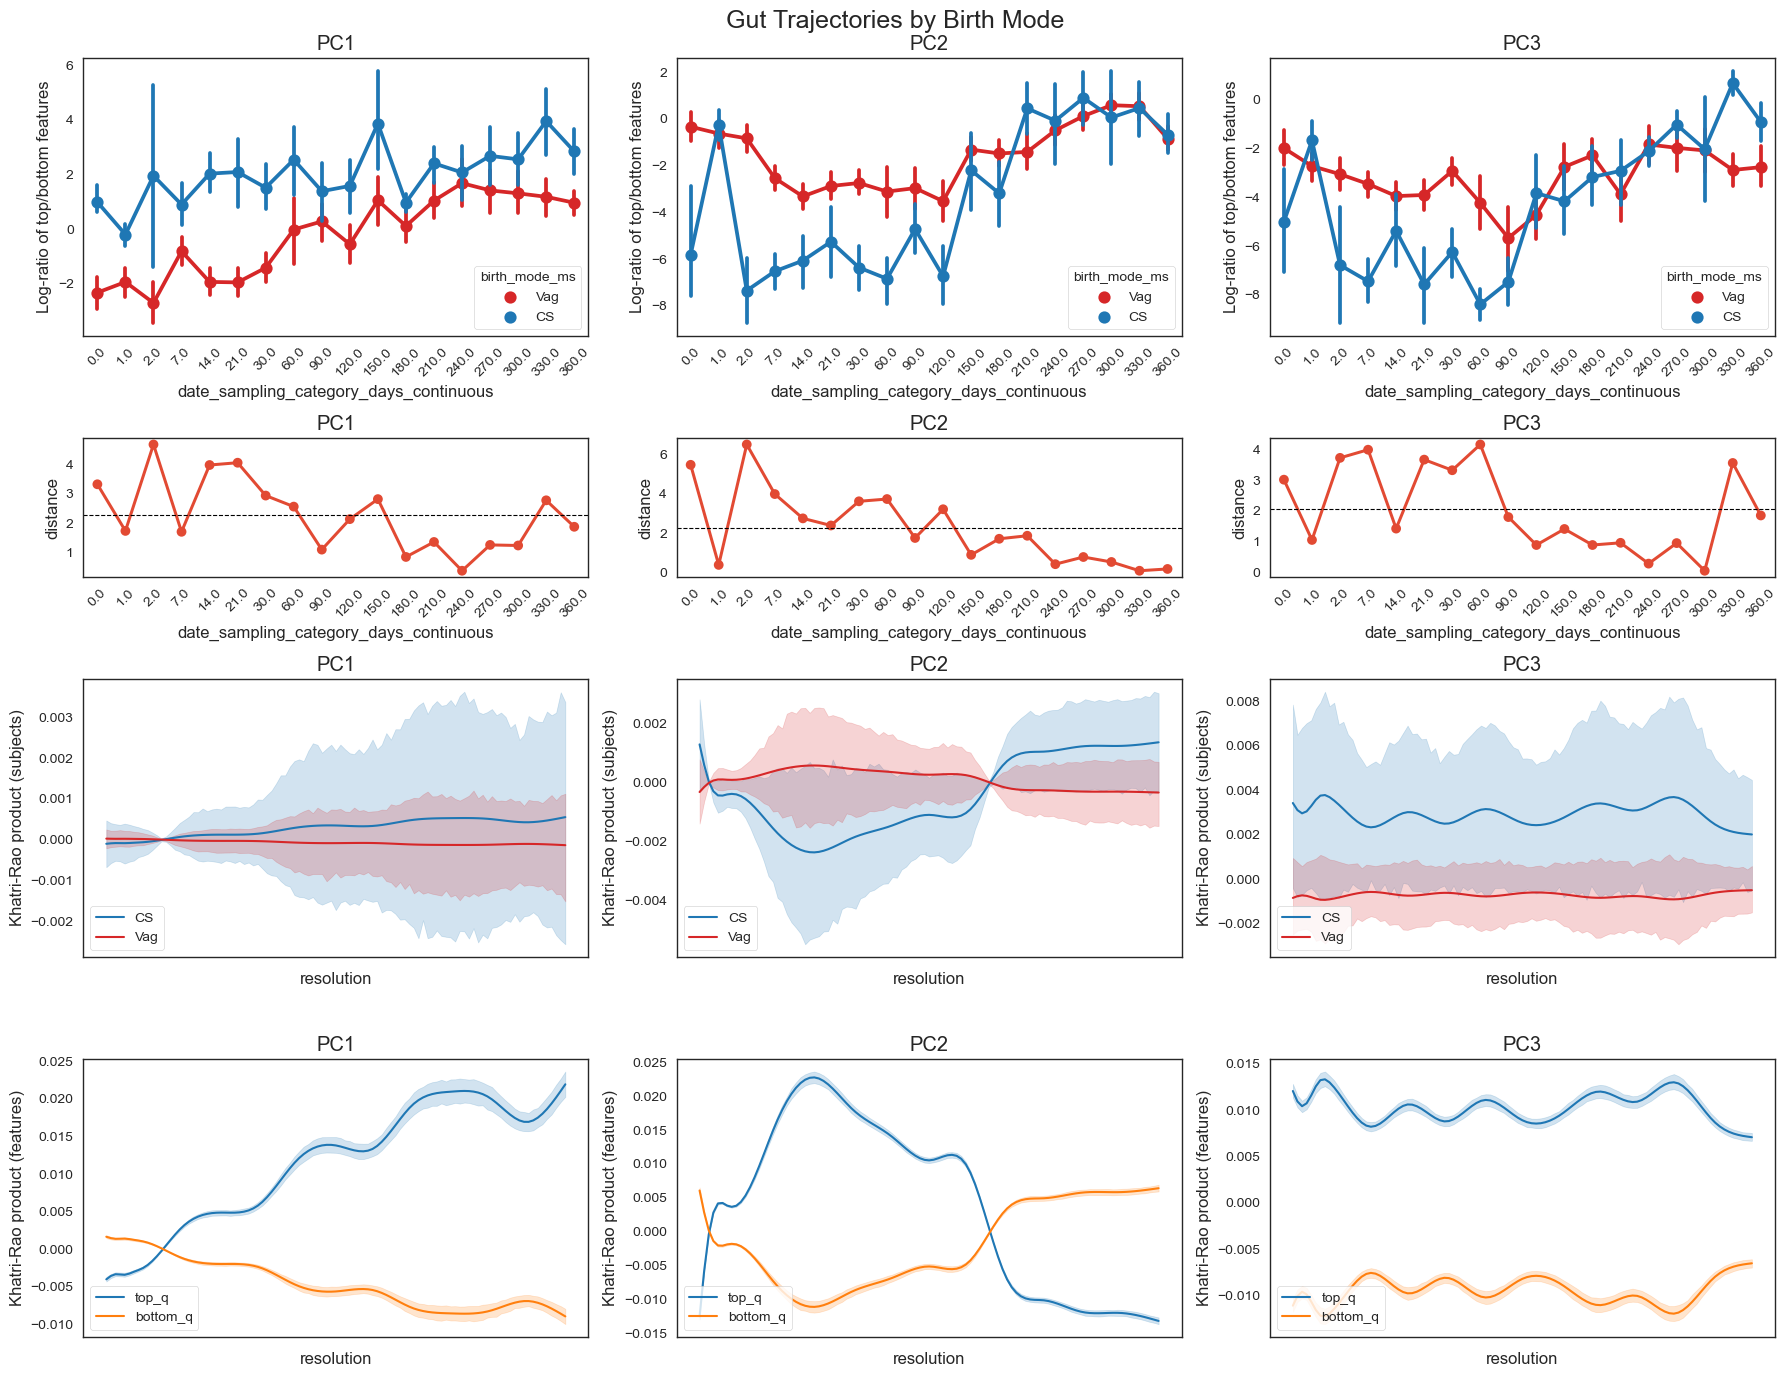

In [20]:
#calculate trajectories based on log-ratio abundance
components = ['component_1', 'component_2', 'component_3']
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
cat_of_interest = 'birth_mode_ms'
quantile = 0.95
mod = '16S.1'
table = table1

#individual_loadings, feature_loadings, state_loadings
fig, axn = plt.subplots(4, 3, figsize=(18, 14), gridspec_kw = {'height_ratios':[6,3,6,6]})
for i, component in enumerate(components):
    beta_l, top_fts, bottom_fts = sub_feat_trajectory(table, feature_loads, component=component,
                                                      modality=mod, pseudocount=0.5, quantile=quantile)
    
    #save top and bottom features
    q_text = int(100*(1 - quantile))
    # pd.DataFrame(top_fts, 
    #              columns=['featureID']).to_csv('{}log_ratio_features/{}_{}_top{}_features_PC{}_{}.txt'.format(output_dir, body_site_save,
    #                                                                                                           body_site1_title, 
    #                                                                                                           q_text, i+1, tps), 
    #              sep='\t', index=False)
    # pd.DataFrame(bottom_fts, 
    #              columns=['featureID']).to_csv('{}log_ratio_features/{}_{}_bottom{}_features_PC{}_{}.txt'.format(output_dir, body_site_save,
    #                                                                                                              body_site1_title, 
    #                                                                                                              q_text, i+1, tps), 
    #              sep='\t', index=False)

    #map columns of interest from mf
    beta_l[state_column] = beta_l.index.map(baby_combined_mf[state_column])
    beta_l['subjectID'] = beta_l.index.map(baby_combined_mf['subjectid_unique'])
    beta_l[cat_of_interest] = beta_l.index.map(baby_combined_mf[cat_of_interest])
    beta_l.dropna(inplace=True)

    #find timepoints at which trajectories seem to converge
    cat1, cat2 = beta_l[cat_of_interest].unique()[0:2]
    beta_l_dist = beta_l.groupby([state_column, 
                                    cat_of_interest]).mean()
    beta_l_dist = beta_l_dist.unstack()
    beta_l_dist.columns = beta_l_dist.columns.droplevel()
    beta_l_dist.reset_index(inplace=True)
    beta_l_dist['distance'] = np.sqrt(abs(beta_l_dist[cat1] - \
                                        beta_l_dist[cat2]) ** 2)

    #calculate trajectories based on khatri-rao product
    strajectory, ftrajectory = temporal_trajectory(subject_loads['16S.1'], feature_loads,
                                                    state_loads, modality=mod,
                                                    state_column='resolution',
                                                    component=component,
                                                    f_subset=True, quantile=0.95)

    #map columns of interest from mf
    strajectory[cat_of_interest] = strajectory['subjectID'].map(mf_all[cat_of_interest])

    ##plotting
    #plot trajectory #1
    sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
                  data=beta_l, ax=axn[0,i], ci=68, palette=group_colors)
    axn[0,i].set_title('PC{}'.format(i+1))
    xlabels = axn[0,i].get_xticklabels()
    axn[0,i].set_xticklabels(xlabels, rotation=45)
    axn[0,i].set_ylabel('Log-ratio of top/bottom features')
    #plot distance between points in trajectory #1
    sns.pointplot(x=state_column, y='distance', data=beta_l_dist, 
                  ax=axn[1,i], errorbar=None, scale=0.8)
    axn[1,i].set_title('PC{}'.format(i+1))
    axn[1,i].axhline(y=beta_l_dist.distance.mean(), color='k', ls='--', lw=0.8)
    axn[1,i].set_xticklabels(xlabels, rotation=45)
    #plot trajectory #2
    sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
                 data=strajectory, ax=axn[2,i], ci=68, palette=group_colors)
    axn[2,i].set_title('PC{}'.format(i+1))
    axn[2,i].legend(loc='lower left')
    axn[2,i].set_xticklabels([], rotation=45)
    axn[2,i].set_ylabel('Khatri-Rao product (subjects)')
    #plot trajectory #3
    sns.lineplot(x='resolution', y=component, hue='quantile', 
                 data=ftrajectory, ax=axn[3,i], ci=68, palette='tab10')
    axn[3,i].set_title('PC{}'.format(i+1))
    axn[3,i].legend(loc='lower left')
    axn[3,i].set_xticklabels([], rotation=45)
    axn[3,i].set_ylabel('Khatri-Rao product (features)')

plt.suptitle('{} Trajectories by Birth Mode'.format(body_site1_title), fontsize=18)
plt.tight_layout()
#plt.savefig('{}png/{}_{}_trajectories_{}.png'.format(output_dir, body_site_save, body_site1_title, tps), dpi=300)
plt.show()

In [ ]:
#calculate trajectories based on log-ratio abundance
components = ['component_1', 'component_2', 'component_3']
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
cat_of_interest = 'birth_mode_ms'
quantile = 0.95
mod = '16S.2'
table = table2

#individual_loadings, feature_loadings, state_loadings
fig, axn = plt.subplots(4, 3, figsize=(18, 14), gridspec_kw = {'height_ratios':[6,3,6,6]})
for i, component in enumerate(components):
    beta_l, top_fts, bottom_fts = sub_feat_trajectory(table, feature_loads, component=component,
                                                      modality=mod, pseudocount=0.5, quantile=quantile)
    
    #save top and bottom features
    q_text = int(100*(1 - quantile))
    pd.DataFrame(top_fts, 
                 columns=['featureID']).to_csv('{}log_ratio_features/{}_{}_top{}_features_PC{}_{}.txt'.format(output_dir, body_site_save,
                                                                                                              body_site2_title, 
                                                                                                              q_text, i+1, tps), 
                 sep='\t', index=False)
    pd.DataFrame(bottom_fts, 
                 columns=['featureID']).to_csv('{}log_ratio_features/{}_{}_bottom{}_features_PC{}_{}.txt'.format(output_dir, body_site_save,
                                                                                                                 body_site2_title, 
                                                                                                                 q_text, i+1, tps), 
                 sep='\t', index=False)

    #map columns of interest from mf
    beta_l[state_column] = beta_l.index.map(baby_combined_mf[state_column])
    beta_l['subjectID'] = beta_l.index.map(baby_combined_mf['subjectid_unique'])
    beta_l[cat_of_interest] = beta_l.index.map(baby_combined_mf[cat_of_interest])
    beta_l.dropna(inplace=True)

    #find timepoints at which trajectories seem to converge
    cat1, cat2 = beta_l[cat_of_interest].unique()[0:2]
    beta_l_dist = beta_l.groupby([state_column, 
                                    cat_of_interest]).mean()
    beta_l_dist = beta_l_dist.unstack()
    beta_l_dist.columns = beta_l_dist.columns.droplevel()
    beta_l_dist.reset_index(inplace=True)
    beta_l_dist['distance'] = np.sqrt(abs(beta_l_dist[cat1] - \
                                        beta_l_dist[cat2]) ** 2)

    #calculate trajectories based on khatri-rao product
    strajectory, ftrajectory = temporal_trajectory(subject_loads['16S.1'], feature_loads,
                                                    state_loads, modality=mod,
                                                    state_column='resolution',
                                                    component=component,
                                                    f_subset=True, quantile=0.95)

    #map columns of interest from mf
    strajectory[cat_of_interest] = strajectory['subjectID'].map(mf_all[cat_of_interest])

    ##plotting
    #plot trajectory #1
    sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
                  data=beta_l, ax=axn[0,i], ci=68, palette=group_colors)
    axn[0,i].set_title('PC{}'.format(i+1))
    xlabels = axn[0,i].get_xticklabels()
    axn[0,i].set_xticklabels(xlabels, rotation=45)
    axn[0,i].set_ylabel('Log-ratio of top/bottom features')
    #plot distance between points in trajectory #1
    sns.pointplot(x=state_column, y='distance', data=beta_l_dist, 
                  ax=axn[1,i], errorbar=None, scale=0.8)
    axn[1,i].set_title('PC{}'.format(i+1))
    axn[1,i].axhline(y=beta_l_dist.distance.mean(), color='k', ls='--', lw=0.8)
    axn[1,i].set_xticklabels(xlabels, rotation=45)
    #plot trajectory #2
    sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
                 data=strajectory, ax=axn[2,i], ci=68, palette=group_colors)
    axn[2,i].set_title('PC{}'.format(i+1))
    axn[2,i].legend(loc='lower left')
    axn[2,i].set_xticklabels([], rotation=45)
    axn[2,i].set_ylabel('Khatri-Rao product (subjects)')
    #plot trajectory #3
    sns.lineplot(x='resolution', y=component, hue='quantile', 
                 data=ftrajectory, ax=axn[3,i], ci=68, palette='tab10')
    axn[3,i].set_title('PC{}'.format(i+1))
    axn[3,i].legend(loc='lower left')
    axn[3,i].set_xticklabels([], rotation=45)
    axn[3,i].set_ylabel('Khatri-Rao product (features)')

plt.suptitle('{} Trajectories by Birth Mode'.format(body_site2_title), fontsize=18)
plt.tight_layout()
plt.savefig('{}png/{}_{}_trajectories_{}.png'.format(output_dir, body_site_save, body_site2_title, tps), dpi=300)
plt.show()

In [ ]:
#calculate trajectories based on log-ratio abundance
components = ['component_1', 'component_2', 'component_3']
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
cat_of_interest = 'birth_mode_ms'

for mod,bsite in zip(['16S.1', '16S.2'],
                     [body_site1_title, body_site2_title]):

    fig, axn = plt.subplots(1, 3, figsize=(18, 4))
    for i, component in enumerate(components):
        strajectory, ftrajectory = temporal_trajectory(subject_loads[mod], feature_loads,
                                                        state_loads, modality=mod,
                                                        state_column='resolution',
                                                        component=component,
                                                        f_subset=True, quantile=0.95)
        #map columns of interest from mf
        strajectory[cat_of_interest] = strajectory['subjectID'].map(mf_all[cat_of_interest])
        strajectory['country'] = strajectory['subjectID'].map(mf_all['country'])
        #plot trajectory
        sns.lineplot(x='resolution', y=component, hue='country', 
                    data=strajectory, ax=axn[i], ci=0)
        axn[i].set_title('PC{}'.format(i+1))
        axn[i].legend(loc='lower left')
        axn[i].set_xticklabels([], rotation=45)
        axn[i].set_ylabel('Khatri-Rao product of loadings')

    plt.suptitle('{} Trajectories by Country'.format(bsite), fontsize=18)
    plt.tight_layout()
    plt.savefig('{}png/{}_{}_trajectories_country_{}.png'.format(output_dir, body_site_save, bsite, tps), dpi=300)
    plt.show()

In [ ]:
# #calculate trajectories based on log-ratio abundance
# components = ['component_1', 'component_2', 'component_3']
# subject_id_column = 'subjectid_unique'
# state_column =  'date_sampling_category_days_continuous'
# cat_of_interest = 'birth_mode_ms'
# quantile = 0.95
# mod = '16S.3'
# site = 'Mouth'
# table = table3

# #individual_loadings, feature_loadings, state_loadings
# fig, axn = plt.subplots(4, 3, figsize=(18, 14), gridspec_kw = {'height_ratios':[6,3,6,6]})
# for i, component in enumerate(components):
#     beta_l, top_fts, bottom_fts = sub_feat_trajectory(table, feature_loadings, component=component,
#                                                       modality=mod, pseudocount=0.5, quantile=quantile)
    
#     #save top and bottom features
#     # q_text = int(100*(1 - quantile))
#     # pd.DataFrame(top_fts, columns=['featureID']).to_csv('{}{}_top{}_features_PC{}_{}.txt'.format(output_dir, site, q_text, i+1, tps), 
#     #                                                     sep='\t', index=False)
#     # pd.DataFrame(bottom_fts, columns=['featureID']).to_csv('{}{}_bottom{}_features_PC{}_{}.txt'.format(output_dir, site, q_text, i+1, tps), 
#     #                                                        sep='\t', index=False)

#     #map columns of interest from mf
#     beta_l[state_column] = beta_l.index.map(baby_combined_mf[state_column])
#     beta_l['subjectID'] = beta_l.index.map(baby_combined_mf['subjectid_unique'])
#     beta_l[cat_of_interest] = beta_l.index.map(baby_combined_mf[cat_of_interest])
#     beta_l.dropna(inplace=True)

#     #find timepoints at which trajectories seem to converge
#     cat1, cat2 = beta_l[cat_of_interest].unique()[0:2]
#     beta_l_dist = beta_l.groupby([state_column, 
#                                     cat_of_interest]).mean()
#     beta_l_dist = beta_l_dist.unstack()
#     beta_l_dist.columns = beta_l_dist.columns.droplevel()
#     beta_l_dist.reset_index(inplace=True)
#     beta_l_dist['distance'] = np.sqrt(abs(beta_l_dist[cat1] - \
#                                         beta_l_dist[cat2]) ** 2)

#     #calculate trajectories based on khatri-rao product
#     strajectory, ftrajectory = temporal_trajectory(individual_loadings['16S.1'], feature_loadings,
#                                                     state_loadings, modality=mod,
#                                                     state_column='resolution',
#                                                     component=component,
#                                                     f_subset=True, quantile=0.95)

#     #map columns of interest from mf
#     strajectory[cat_of_interest] = strajectory['subjectID'].map(mf_all[cat_of_interest])

#     ##plotting
#     #plot trajectory #1
#     sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
#                   data=beta_l, ax=axn[0,i], ci=68, palette=group_colors)
#     axn[0,i].set_title('PC{}'.format(i+1))
#     xlabels = axn[0,i].get_xticklabels()
#     axn[0,i].set_xticklabels(xlabels, rotation=45)
#     axn[0,i].set_ylabel('Log-ratio of top/bottom features')
#     #plot distance between points in trajectory #1
#     sns.pointplot(x=state_column, y='distance', data=beta_l_dist, 
#                   ax=axn[1,i], errorbar=None, scale=0.8)
#     axn[1,i].set_title('PC{}'.format(i+1))
#     axn[1,i].axhline(y=beta_l_dist.distance.mean(), color='k', ls='--', lw=0.8)
#     axn[1,i].set_xticklabels(xlabels, rotation=45)
#     #plot trajectory #2
#     sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
#                  data=strajectory, ax=axn[2,i], ci=68, palette=group_colors)
#     axn[2,i].set_title('PC{}'.format(i+1))
#     axn[2,i].legend(loc='lower left')
#     axn[2,i].set_xticklabels([], rotation=45)
#     axn[2,i].set_ylabel('Khatri-Rao product (subjects)')
#     #plot trajectory #3
#     sns.lineplot(x='resolution', y=component, hue='quantile', 
#                  data=ftrajectory, ax=axn[3,i], ci=68, palette='tab10')
#     axn[3,i].set_title('PC{}'.format(i+1))
#     axn[3,i].legend(loc='lower left')
#     axn[3,i].set_xticklabels([], rotation=45)
#     axn[3,i].set_ylabel('Khatri-Rao product (features)')

# plt.suptitle('{} Trajectories by Birth Mode'.format(site), fontsize=18)
# plt.tight_layout()
# plt.show()

In [ ]:
#plot covariance of a subset of features
plot_feature_cov(tables=[table1_clr, table2_clr], mod_cov=feature_covs, 
                 components=['component_1', 'component_2', 'component_3'])
plt.tight_layout()
plt.savefig('{}png/{}_feature_covariance_{}.png'.format(output_dir, body_site_save, tps), dpi=300)